<a href="https://colab.research.google.com/github/boscodeeromeu/NN/blob/main/LogitPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Logistic Regression with Pytorch


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------


In this first lab of the course, you will learn basic aspects about how to use [Pytorch](https://pytorch.org/) to train a logistic regressor in a binary classification problem. 

Pytorch is a powerful library to address Machine Learning problems in general, and deep learning problems in particular, as it provides with automatic differentiation tools. Namely, in our programs we will define functions $f_{\mathbf{w}}(x)$ of given input data $x$ and some parameters $\mathbf{w}$ to be optimized, and we will use Pytorch's [autograd package](https://pytorch.org/docs/stable/autograd.html) to automatically compute $\nabla_{\mathbf{w}} f_{\mathbf{w}}(x)$, and then use the gradient into a Stochastic Gradient Descent (SGD) routine.

But lets go step by step. First of all, we will load some database and perform some pre-processing. To do so, we will use the **[Python Data Analysis Library](https://pandas.pydata.org/)** (a.k.a. pandas).


In [ ]:
import pandas as pd # pd is simply an alias 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #High quality figures

## Part I. Pre-processing a real dataset

The [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) contains 10 features related to breast tumors that have been diagnosed as benign or malignant. You have a description of the 10 features in the link above. In the same link you can download the data set as a CSV file. 

We will import it directly using the following class

In [ ]:
def load_spam():
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',header=None)
    data.columns=['ID', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses', 'Class']
    return data

In [ ]:
''' Data is stored in a Dataframe, a particular data type implemented in Pandas'''

data = load_spam()


Lets visualize the first 10 entries of the database with the `.head()` method

In [ ]:
data.head(10)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


With the `.shape()` method we can check how many datapoints we have

In [ ]:
print('There are %d data points. Each one of dimension %d' %(data.shape[0],data.shape[1]))

There are 699 data points. Each one of dimension 11


We will do the following preprocessing steps. All of them are implemented in Pandas (it is advisory for very large databases):

- Remove the 'ID' column. We won't use it anymore

- Analyze missing data (Encoded in this database with a '?' by the column mode). 

- The tumor class is equal to 2 for bening tumors and to 4 for malignat tumors. We will replace this by 0 and 1 respectively

- Create a train set and a test set

- We will normalize all input variables so they all have zero mean and unit variance

### Remove ID colum

We can use the `.drop()` method. We use the input `inplace=True` to override the existing Dataframe.

In [ ]:
data.drop('ID', axis=1, inplace=True)

In [ ]:
# Lets check the result

data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2
5,8,10,10,8,7,10,9,7,1,4
6,1,1,1,1,2,10,3,1,1,2
7,2,1,2,1,2,1,3,1,1,2
8,2,1,1,1,2,1,1,1,5,2
9,4,2,1,1,2,1,2,1,1,2


### About missing data

Pandas considers values like `NaN` and `None` to represent missing data. The `pandas.isnull` function can be used to tell whether or not a value is missing. 

Let's use `apply()` across all of the columns in our DataFrame to figure out which values are missing. But first we  change the `?` missing codification by `NaN`.

In [ ]:
data.replace('?', np.nan, inplace=True)

In [ ]:
empty = data.apply(lambda col: pd.isnull(col))

In [ ]:
empty.sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

Observe that only one of the columns has 16 missing entries. For simplicity, let's remove this column. Be aware that in general we will impute missing data with some representative value. 

In [ ]:
data.drop('Bare Nuclei', axis=1, inplace=True)

In [ ]:
empty = data.apply(lambda col: pd.isnull(col))
empty.sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

### Create a binary class label

To do so, we will create a simple function to convert the label and store the result in a new colum of the dataframe

In [ ]:
def convert_to_binary(l):
    return (l-2.0)/2

In [ ]:
# We create the new column

data['Binary Class'] = data[['Class']].apply(lambda l: convert_to_binary(l))

data.drop('Class', axis=1, inplace=True)

Lets take a look to the histogram of the binary class label

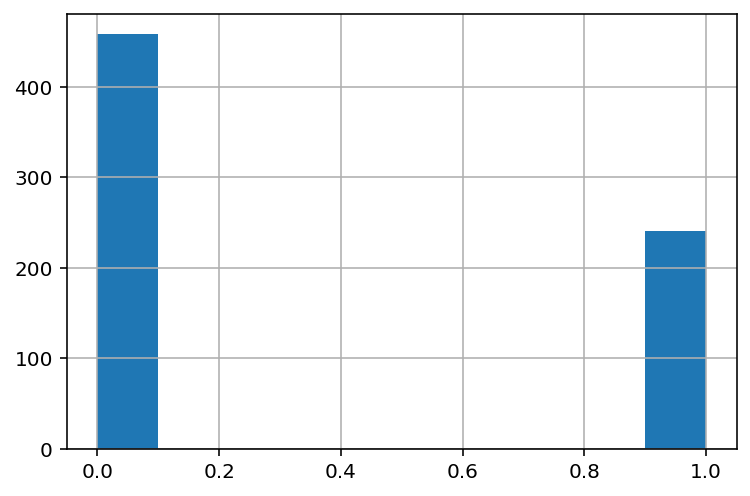

In [ ]:
data['Binary Class'].hist()

### Create a train and test sets

We will simply split the dataset at random. 80% of the data will go to the training set, the rest to the test set. We will use [Numpy's random permutation function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.permutation.html) and the `.iloc()` method. 

In [ ]:
frac_train = 0.8

data_train = int(data.shape[0]*frac_train) # Training points

np.random.seed(seed=10) #To fix the random seed. So we all get the same partition

mask = np.random.permutation(data.shape[0]) # Random order of data indexes

train_data = data.iloc[list(mask[:data_train])].copy()

test_data = data.iloc[list(mask[data_train:])].copy()


Note that we store the train and test data in separate Dataframes, so we can normalize them without modifying the original data (we could add more columns to the original Dataframe, but this would be later on annoying to index).

Also, the train/test partition and normalization can also easily done using Numpy and the [sklearn library](https://scikit-learn.org/stable/).

### Normalize input variables 

In general, it is not recommended that input variables (or features) are defined in different ranges. I.e., $x_1$ for instance takes values in the $[-1,1]$ set and $x_2$ takes values in the $[-10^6,10^6]$ range. 

To improve both the numerical robustness of our estimators and **enhance interpretability**, we will apply a linear normalization preprocessing stage to use as input to the linear regression features with (sample) mean 0 and (sample) variance equal to 1. 

Given the unnormalized feature matrix $\mathbf{X}_{N\times D}$, we compute the sample mean per feature column, $\mu_j$, and the sample variance per  feature column, $\sigma^2_j$ for $j=1,\ldots,D$. Then, each row of the normalized feature matrix $\overline{\mathbf{X}}_{N\times D}$ is obtained as follows:

$$\overline{\mathbf{x}}^{(i)}= \left[\frac{x_1^{(i)}-\mu_1}{\sqrt{\sigma^2_1}}, ~~ \frac{x_1^{(i)}-\mu_2}{\sqrt{\sigma^2_2}}, \ldots, \frac{x_1^{(D)}-\mu_1}{\sqrt{\sigma^2_D}}\right]$$

**Note this does not affect to the logistic regression solution**, we are simply re-scaling the parameter vector $\boldsymbol{w}$. Using this scaling, we can now effectively compare the effect that each variable has in the logistic regression solution: **the larger $|w_j|$ is, the more effect the $j$-th feature has in the estimation of the class**.

One important aspect is that the test set is normalized **using the train set statistics (mean and variance)**

In [ ]:
means = train_data.mean()
stds = train_data.std()

In [ ]:
for idx, column_name in enumerate(train_data.columns[:-1]):#we exclude the target obviously
    train_data[column_name] = (train_data[column_name]-means[idx])/(stds[idx])
    test_data[column_name] = (test_data[column_name]-means[idx])/(stds[idx])

Lets take a look to the resulting dataframe

In [ ]:
train_data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Binary Class
285,1.300525,2.285664,2.276496,2.455409,2.286331,2.658239,1.330666,0.867001,1.0
607,-1.212539,-0.700359,-0.747811,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
587,0.223498,-0.700359,-0.747811,-0.642951,-0.552749,-0.603117,-0.284977,-0.338605,0.0
458,0.223498,-0.700359,-0.411777,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
431,0.223498,-0.700359,-0.747811,0.045573,0.393611,-0.195448,-0.284977,-0.338605,0.0
52,2.018543,-0.036799,0.932359,-0.298689,-0.079569,0.212222,2.300052,0.264198,1.0
560,0.223498,-0.700359,-0.747811,-0.642951,-0.552749,-0.195448,-0.608106,-0.338605,0.0
445,-0.853530,-0.700359,-0.747811,-0.642951,-0.552749,-1.010787,-0.608106,-0.338605,0.0
292,1.300525,1.622103,1.604428,-0.642951,-0.552749,1.027561,2.300052,-0.338605,1.0
579,-1.212539,-0.700359,-0.747811,-0.642951,-0.552749,-0.195448,-0.608106,-0.338605,0.0


## Part II. Tensors in Pytorch


Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

PyTorch in a lot of ways behaves like  Numpy arrays. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients and another module specifically for building neural networks. 

It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.


### Creating and manipulating tensors

In [ ]:
# First, import PyTorch
import torch

In [ ]:
# To check what torch version you're using

torch.__version__

'1.8.0+cu101'

Lets create a function to manipulate torch tensors. Let's program our own logistic regressor

$$f(\mathbf{x}) = \frac{1}{1+\exp-(\mathbf{w}^T\mathbf{x}+w_0)}=\sigma(\cdot)$$

where $\mathbf{w}$ and $w_0$ (the bias or intercept) are initialized with Pytorch tensors containing random numbers drawn from a i.i.d. Normal Gaussian distribution. Also, to test the function, we will generate data points $\mathbf{x}$ also as random tensors.

#### First we define the sigmoid function $\sigma(\cdot)$

In [ ]:
def sigmoid(x):
    """ Sigmoid activation function 
    
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

#### Now we generate the parameters $\mathbf{w},w_0$ and one input vector (feature vector) $\mathbf{x}$

In [ ]:
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are 5 random normal variables
feature_vector = torch.randn((1, 5))
# True weights for our data, random normal variables again
weights = torch.randn_like(feature_vector)
# and a true bias term
bias = torch.randn((1, 1))

Above we generated data we can use to get the output of our simple neural network. This is all just random for now, going forward we'll start using normal data. Going through each relevant line:

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

Finally, `bias = torch.randn((1, 1))` creates a single value from a normal distribution.

PyTorch tensors can be added, multiplied, subtracted, etc, just like Numpy arrays. In general, you'll use PyTorch tensors pretty much the same way you'd use Numpy arrays.

Just like in Numpy, you can check the values and dimensions of a tensor:


In [ ]:
print(feature_vector)
m, n = feature_vector.shape
print("The dimensions are {0}, {1}".format(m, n))

tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])
The dimensions are 1, 5


> **Exercise**: Using the `sigmoid()` function, calculate the output a binary logistic regressor with input feature vector `feature_vector`, weights `weights`, and bias `bias`. You can use `*` for Tensor elemenwise product and the function  [`torch.sum()`](https://pytorch.org/docs/stable/torch.html#torch.sum) to sum all the elements of a tensor in a certain dimension. 

In [ ]:
y = sigmoid(bias + torch.sum(feature_vector*weights))

In [ ]:
print("The ouput of the LR is {0}".format(y[0][0])) 

The ouput of the LR is 0.15950655937194824


#### Do the same but using matrix multiplication with `torch.mm()`


You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.  For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm) or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting.

First, check the dimension of `feature_vector` and `weights` using the method `.shape`

In [ ]:
print(feature_vector.shape)
print(weights.shape)

torch.Size([1, 5])
torch.Size([1, 5])


See what comes if you try to directly multiply both tensors

In [ ]:
torch.mm(feature_vector, weights)

RuntimeError: ignored

What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. There are a few options here: [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape), and [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

Any of the two methods will work for this. So, now we can reshape `weights` to have five rows and one column with something like `weights.view(5, 1)`.


> **Exercise**: Calculate the output of the logistic regressor using matrix multiplication.

In [ ]:
y = sigmoid(bias + torch.mm(feature_vector, weights.reshape(5,1)))

In [ ]:
print("The ouput of the LR is {0}".format(y[0][0])) 

The ouput of the LR is 0.15950657427310944


### Numpy to Torch and back

PyTorch has a feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [ ]:
a = np.random.rand(4,3)
a

array([[0.331844  , 0.06143108, 0.59817351],
       [0.88592025, 0.41213378, 0.0382722 ],
       [0.0808424 , 0.08191454, 0.80936733],
       [0.800694  , 0.01690981, 0.86129433]])

In [ ]:
b = torch.from_numpy(a)
b

tensor([[0.3318, 0.0614, 0.5982],
        [0.8859, 0.4121, 0.0383],
        [0.0808, 0.0819, 0.8094],
        [0.8007, 0.0169, 0.8613]], dtype=torch.float64)

In [ ]:
b.numpy()

array([[2.36060715, 1.4667084 , 0.15785968],
       [5.94656986, 0.30634723, 3.46943735],
       [6.65667809, 0.10766847, 4.07468313],
       [3.8363896 , 0.23723953, 0.09142821]])

The **memory is shared between the Numpy array and Torch tensor**, so if you change the values in-place of one object, the other will change as well.

In [ ]:
# Multiply PyTorch Tensor by 2, in place (Note the _)
b.mul_(2)

tensor([[0.6637, 0.1229, 1.1963],
        [1.7718, 0.8243, 0.0765],
        [0.1617, 0.1638, 1.6187],
        [1.6014, 0.0338, 1.7226]], dtype=torch.float64)

In [ ]:
# Numpy array matches new values from Tensor
a

array([[0.663688  , 0.12286216, 1.19634702],
       [1.77184051, 0.82426755, 0.0765444 ],
       [0.16168481, 0.16382908, 1.61873467],
       [1.60138801, 0.03381962, 1.72258865]])

## Part III. Define a logistic regression and the loss function in Pytorch

### The `nn.()` module

PyTorch provides a module `nn` that makes building neural networks much simpler. 


In [ ]:
from torch import nn

You should get use to inspect [Pytorch official documentation](https://pytorch.org/docs/stable/index.html) to understand the structure and usability of methods and classes required to work with Pytorch and train neural networks.

With the following code I show you how to create a Logistic Regression network whose parameters will be later on optimized for our data.

In [ ]:
class LR(nn.Module):
    def __init__(self, dimx):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(dimx, 1), requires_grad = True)
        
        self.bias = nn.Parameter(torch.randn(1, 1), requires_grad = True)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.sigmoid(torch.matmul(x, self.weights)+self.bias)
        return x

Let's go through this step by step.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your neural network. The name of the class itself can be anything.

```python
self.weights = nn.Parameter(torch.randn(dimx,1),requires_grad = True)
self.bias = nn.Parameter(torch.randn(1,1),requires_grad = True)
```

The Parameter class defines a kind of Tensor that is to be considered a module parameter. Namely, we will optimize the values of these tensors. Note that we define a **random initialization** with `torch.randn()`.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.


### A more compact definition of the network using pre-defined layers

The `.nn` package provides us with predefined layers and operators so that the implementation of our networks is indeed much easier (and compact). The following code performs exactly as the class `LR` defined above.

In [ ]:
class LR_compact(nn.Module):
    def __init__(self,dimx):
        super().__init__()
        
        self.output = nn.Linear(dimx, 1)
        #first element is the number of input features
        #second element is the number of output features # so this will be used for the linear operations of each perceptron
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.sigmoid(x)
        return x

When we define a logistic regressor by instantiating the class `LR_compact`, we can access the weights and the bias as `self.output.weight` and `self.output.bias`

### Evaluate the logistic regressor using our data

Lets go back to the database we just preprocessed above. Consider now the first 10 datapoints in the training set.

In [ ]:
x = np.array(train_data[:10]).astype(np.float32) # train_data is a Dataframe, can easily be converted to a numpy array
y = x[:, -1]    # Last Column is the class
x = x[:, :-1]   # We remove the last column from x

In [ ]:
print("The dimensions of x are ({0},{1})\n".format(x.shape[0], x.shape[1]))
print(x)
print("The dimension of y is ({0})\n".format(y.shape[0]))
print(y)

The dimensions of x are (10,9)

[[-0.811616    1.300525    2.2856638   2.2764957   2.4554093   2.2863305
   2.6582384   1.3306657   0.8670005 ]
 [-0.98318946 -1.2125387  -0.7003592  -0.7478111  -0.6429514  -0.55274856
  -1.010787   -0.60810614 -0.3386047 ]
 [ 0.2754474   0.22349761 -0.7003592  -0.7478111  -0.6429514  -0.55274856
  -0.60311747 -0.2849775  -0.3386047 ]
 [ 0.28192046  0.22349761 -0.7003592  -0.41177702 -0.6429514  -0.55274856
  -1.010787   -0.60810614 -0.3386047 ]
 [ 0.29667392  0.22349761 -0.7003592  -0.7478111   0.04557319  0.39361116
  -0.195448   -0.2849775  -0.3386047 ]
 [ 0.05097196  2.018543   -0.03679854  0.93235934 -0.29868913 -0.07956871
   0.21222152  2.3000517   0.26419792]
 [ 0.36454394  0.22349761 -0.7003592  -0.7478111  -0.6429514  -0.55274856
  -0.195448   -0.60810614 -0.3386047 ]
 [-0.36715612 -0.8535297  -0.7003592  -0.7478111  -0.6429514  -0.55274856
  -1.010787   -0.60810614 -0.3386047 ]
 [-0.75790435  1.300525    1.6221032   1.6044276  -0.6429514  -0.

> **Exercise:** Instantiate the class `LR_compact` with the dimension of every data point in `x`

In [ ]:
first_logit = LR_compact(x.shape[1])

> **Exercise:** Print the current parameters of the classifier (weight vector and bias)

In [ ]:
print("The weights of the model are: \n\n{}\n\nThe bias of the model is:\n\n{}".format(first_logit.output.weight.tolist()[0],
                                                                       first_logit.output.bias[0]))

The weights of the model are: 

[0.013953368179500103, 0.0621541365981102, 0.25313612818717957, 0.0857260674238205, 0.1768491268157959, -0.2578529715538025, 0.2372952699661255, 0.11472304910421371, 0.08443371951580048]

The bias of the model is:

0.046048443764448166


To evaluate the logistic regressor output for the data in `x`, we make use of the class `forward` method. Do not forget to feed the function with a **torch tensor**.

In [ ]:
output = first_logit.forward(torch.tensor(x))

In [ ]:
print(output)

tensor([[0.8307],
        [0.3558],
        [0.4126],
        [0.3874],
        [0.4065],
        [0.6335],
        [0.4274],
        [0.3629],
        [0.7636],
        [0.4033]], grad_fn=<SigmoidBackward>) [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]


Above we can see the operation that created `output`, a sigmoid operation `SigmoidBackward`. The autograd module keeps track of **all operations that affect Parameter tensors** and use such information to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. 

### Evaluating the binary cross entropy function using `nn.BCE()`

Let's reduce the tensor `y` to a scalar value, the binary cross entropy. We will use the class `nn.BCE()`. See how to use the function in the [official documentation](https://pytorch.org/docs/stable/nn.html).

In [ ]:
bce = nn.BCELoss()

In [ ]:
loss = bce(output, torch.tensor(y).view(output.shape[0], 1))

print(loss)

tensor(0.4420, grad_fn=<BinaryCrossEntropyBackward>)


In [ ]:
torch.tensor(y).view(output.shape[0], 1)

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

Above we can see the operation that created `loss`, a binary cross entropy `BinaryCrossEntropyBackward`.


Now that we know how to calculate a loss, Torch provides a module, `autograd`, for automatically calculating the gradients of the loss w.r.t. the tensors. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.
To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`. By default, all tensors created by instantiating the class `nn.Parameter` have `requires_grad = True`.

> **Exercise**: Check that both the weights and the bias of the object have this flag set to `True`

In [ ]:
print(first_logit.output.weight.requires_grad_())
print(first_logit.output.bias.requires_grad_())


Parameter containing:
tensor([[ 0.0140,  0.0622,  0.2531,  0.0857,  0.1768, -0.2579,  0.2373,  0.1147,
          0.0844]], requires_grad=True)
Parameter containing:
tensor([0.0460], requires_grad=True)


You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`. Turning off gradients is recommended for instance when you are just evaluating you network, i.e., when training is finished and only parameter evaluation is required.


### The `.backward()` operator


The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`. This means that when we calculate the loss and call `loss.backward()`, the gradients of the loss function w.r.t. the parameters are calculated. These gradients are used to update the weights with gradient descent.

After calling  `loss.backward()` the gradient of `loss` w.r.t. to any tensor `x` can be accessed as `x.grad`


> **Exercise**: Print the gradient of the loss function w.r.t. the model parameters for the `LR` object (or the `LR_compact`) before and after running `loss.backward()`.

In [ ]:
print(first_logit.output.weight.grad)
print(first_logit.output.bias.grad)

loss.backward(retain_graph=True)

print(first_logit.output.weight.grad)
print(first_logit.output.bias.grad)

tensor([[ 0.0164, -0.2132, -0.2687, -0.3037, -0.1646, -0.1366, -0.2379, -0.3023,
         -0.1097]])
tensor([0.1984])


RuntimeError: ignored

> **Exercise**: Complete the following code, in which given the tensor $u$ (of size $10\times1$), you have to evaluate the gradient of $y=u^T~u$ w.r.t. every component of $u$. Does it coincide with the analytical solution?

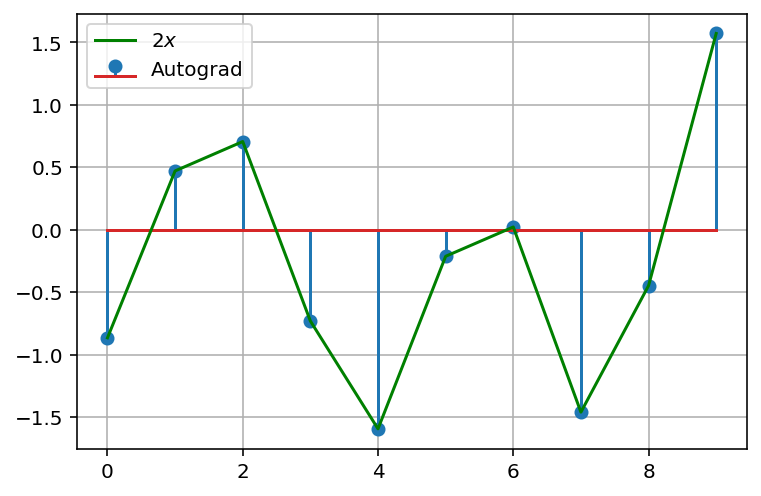

In [ ]:
u = torch.randn(10, 1, requires_grad=True)

#YOUR CODE HERE (2 lines of code)
y = torch.matmul(u.T,u)
y.backward()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    plt.stem(u.grad.numpy(), label='Autograd', use_line_collection=True)
    plt.plot(2*u.detach().numpy(), '-g', label='$2x$')
    plt.grid()
    plt.legend()

#esto ultimo plot es obvio como y = u*u pues la derivada es simplemente 2*u, de ahi que veamos
#que son iguales

`.detach()` method constructs a new view on a tensor which is declared not to need gradients. You can see a nice example in this [link](http://www.bnikolic.co.uk/blog/pytorch-detach.html). Typically, we will use detach to export values to numpy to perform model evaluation. In Pytorch, you cannot call the `.numpy()` operators in Tensor that has `require_grad=True`.

An important aspects to implement Gradient Descent Loops is that if call again the `.backward()` operator, then **gradients are accumulated** in the variable `x.grad`. 

If we recompute `y`, we can check that gradients are accumulated by calling again `y.backward()` 

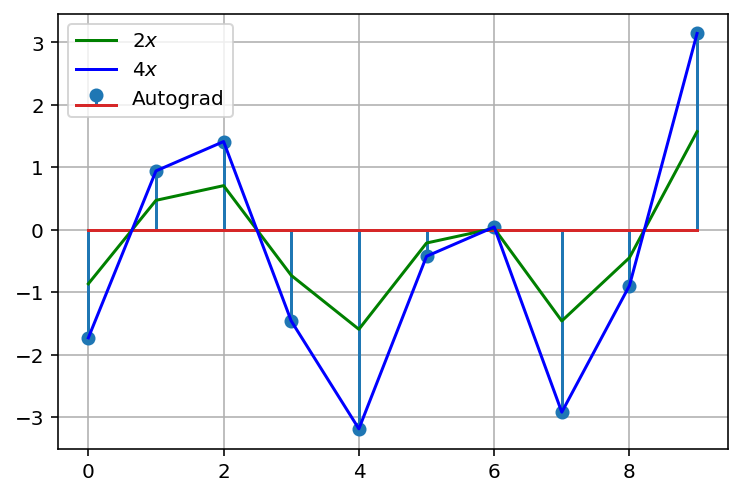

In [ ]:
y = torch.matmul(u.view(1, 10), u)
y.backward()

plt.stem(u.grad.numpy(), label='Autograd', use_line_collection=True)
plt.plot(2*u.detach().numpy(), '-g', label='$2x$')
plt.plot(4*u.detach().numpy(), '-b', label='$4x$')
plt.grid()
plt.legend()

In [ ]:
print(u)

tensor([[-0.4326],
        [ 0.2354],
        [ 0.3529],
        [-0.3652],
        [-0.7968],
        [-0.1062],
        [ 0.0111],
        [-0.7301],
        [-0.2239],
        [ 0.7855]], requires_grad=True)


To **reset gradients**, Pytorch optimizers provide us with the appropiate method.

## Part IV. Train the logistic regressor with the complete dataset

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backward pass.

In [ ]:
# We use all data points  

x = np.array(train_data).astype(np.float32)
# Last Column is the class
y = x[:, -1]  
x = x[:, :-1]

In [ ]:
output = my_classifier.forward(torch.tensor(x))

loss = bce(output,torch.tensor(y).view(output.shape[0],1))

loss.backward()

print(my_classifier.output.weight.grad.shape)

### Defining an optimizer

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

With the following code, we can define the optimizer:


In [ ]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(my_classifier.parameters(), lr=0.01)

To perform a SGD iteration, we simply call `optmizer.step()`


By the way, `my_classifier.parameters()` returns a [generator object](https://realpython.com/introduction-to-python-generators/). Namely, a list with all the parameters that you read one by one or iterate through a for loop.

In [ ]:
params = my_classifier.parameters()

print(type(params))
# We print the first set of parameters (weight vector)
print(next(params))
# We print the second set of parameters (the bias)
print(next(params))

If we call again the method `next()` over params, Python will yield a `StopIteration` error:

In [ ]:
print(next(params))

## Creating a class with both the network and a training method

Object Oriented Programming (OOP) in Python is a versatil and convenient method to implement our own software and create reusable sofware. Indeed, along this whole notebook, we have been using classes all the time.

[Here](https://www.programiz.com/python-programming/object-oriented-programming) you can find a short introduction to OOP in Python.

With the following code, we will define a class that incorporates the definition of the logistic regression network and **a method to train the parameters**. Go carefully through the code and try to understand it line by line.

In [ ]:
''' This class inherits from the LR_compact class. So it has the same atributes
and methods, and some others that we will add. 
'''
class LR_extended(LR_compact):
    
    def __init__(self, dimx, sgd_iterations=1000, lr=0.001, print_every=200):
        
        super().__init__(dimx)  #To initialize LR_compact!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.sgd_iterations = sgd_iterations #SGD steps
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.print_every = print_every
        
    def train(self,x,y):
        
        # SGD Loop
        
        for iter in range(int(self.sgd_iterations)):
        
            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.forward(x)

            loss = self.criterion(out, y.view(x.shape[0], 1))

            self.loss_during_training.append(loss.item())

            loss.backward()

            self.optim.step()
        
            if(iter % self.print_every == 0): # Every 1000 iterations
                
                print("Training loss after %d iterations: %f" 
                      %(iter,self.loss_during_training[-1]))
        

Lets instantiate the class and train the logistic regressor. See how compact and easy is now (OOP is great!).

In [ ]:
my_LR = LR_extended(x.shape[1], sgd_iterations=3000, lr=0.001)

my_LR.train(torch.tensor(x), torch.tensor(y))

Note that if you believe that training isn't finished yet, you can simply call again the `.train()` method.

In [ ]:
my_LR.train(torch.tensor(x), torch.tensor(y))

> **Exercise**: Train from scratch the logistic regressor for 20.000 iterations and plot the evolution of the binary cross entropy loss.

In [ ]:
# YOUR CODE HERE


> **Exercise**: Print all model parameters (e.g. weights and bias)

In [ ]:
# YOUR CODE HERE


#### Evaluating the model in the test set

Now that we have trained our logistic regressor, it is time to compare its performance in both the training and the test sets.

> **Exercise**: Compute the logistic regressor output for both the training data and the test data.

In [ ]:
out_train = my_LR.forward(torch.tensor(x))

# YOUR CODE HERE


Recall that the logistic regressor output is an estimated class probability. Assuming we put the threshold at a probability of 0.5, lets count the number of correct predictions in both sets.

In [ ]:
accuracy_rate_train = np.sum((out_train.detach().numpy()>=0.5) 
                          == y.reshape([-1, 1]))/y.shape[0]

accuracy_rate_test = np.sum((out_test.detach().numpy()>=0.5) 
                         == ytest.reshape([-1, 1]))/ytest.shape[0]

print(accuracy_rate_train)

print(accuracy_rate_test)

## Part V. Training a Logistic Regressor with mini-batch stochastic gradient descent

Finally, we are going to implement an scalable version of the gradient descent training implemented above. At every iteration, instead of evaluating the gradient using all data points, a small minibatch of data will be used.

To make sure that all training data points are evenly used to evaluate the gradient, we will use a short iterating function. Instead of predefining a certain number of SGD iterations, we define a certain number of **epochs**. After every epoch **all datapoints** have been used in the optimizer once. 


> **Exercise**: Complete the code for the following class

In [ ]:
''' This class inherits from the LR_compact class. So it has the same atributes
and methods, and some others that we will add. 
'''
class LR_stochastic(LR_compact):
    
    def __init__(self, dimx, num_train_data,
                 epochs=100, lr=0.001, batch_size=50, print_every=20):
        
        super().__init__(dimx)  #To initialize LR2!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.print_every = print_every  # Print loss every 
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.num_train = num_train_data
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
        
    def train(self, x, y):
        
        # SGD Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                # Indexes of the datapoints that enter the batch
            
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                out = self.forward(x[idx_batch,:]) 

                
                loss = #YOUR CODE HERE


                running_loss += loss.item()

                #YOUR CODE HERE. Compute gradients
                
                
                #YOUR CODE HERE. Perform one SGD step
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)

            if(e % self.print_every == 0): 

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


> **Exercise**: Train a logistic regressor with minibatch-stochastic gradient descent with different batch sizes (10,20,50 and 100) and plot the evolution of the loss function for all cases in the same plot. 
Also, compare with the evolution of the loss function when all data is used. Note that when all datapoints are used, every GD iteration correspond to a **full epoch**. Explain the results.
>
> Finally, observe if in all cases the parameters of the models (weights and biases) are similar.

In [ ]:
#YOUR CODE HERE


> **Exercise**: Add a method to the above class that evaluates the classification accuracy rate for a given set of data points and the corresponding labels. Hint: we have done this previously in the notebook, you only  have to encapsulate it in the class as a new method.
>
>Recall to disable gradient computation for these computations (it saves time and operations!)
>
> Then, train the model, plot the loss function per epoch and print the accuracy rate.

In [ ]:
#YOUR CODE HERE


## Part VI. Regularize the model weights

> **Exercise**: Implement a class for regularized logistic regression, in which you penalize the $L_2$ norm of the weights (do not penalize for the bias). Use a pre-defined regularization parameter that you specify when instantiate the class.
>
> Recall that $L_2$ is simply the sum of the squared elements of a vector.  For a given tensor `u` you can get this 
> norm by calling `torch.norm(u)`, which returns the squared-root of the norm. The idea is that you add this norm to the loss function, with a regularization parameter $\lambda$:
>
> $$\mathcal{L}_{reg} = \mathcal{L}_{BCE} + \lambda ||\mathbf{w}||^2_2$$
>
> Train the model with SGD and compare the train/test performance as you vary $\lambda$. Hint: Since in this case the unregularized LR model performs really well on both train and test datasets, there is actually no need for   regularization. So do not expect much improvement, rather the contrary. We will reuse this code in future projects.
>
> Explain the differences you see when changing the value of $\lambda$.



In [ ]:
#YOUR CODE HERE
